In [1]:
import sys
sys.executable

'/Users/heavenly/opt/anaconda3/envs/mqed/bin/python'

# How to use your private chatbot using Langchain

### All you need is langchain!

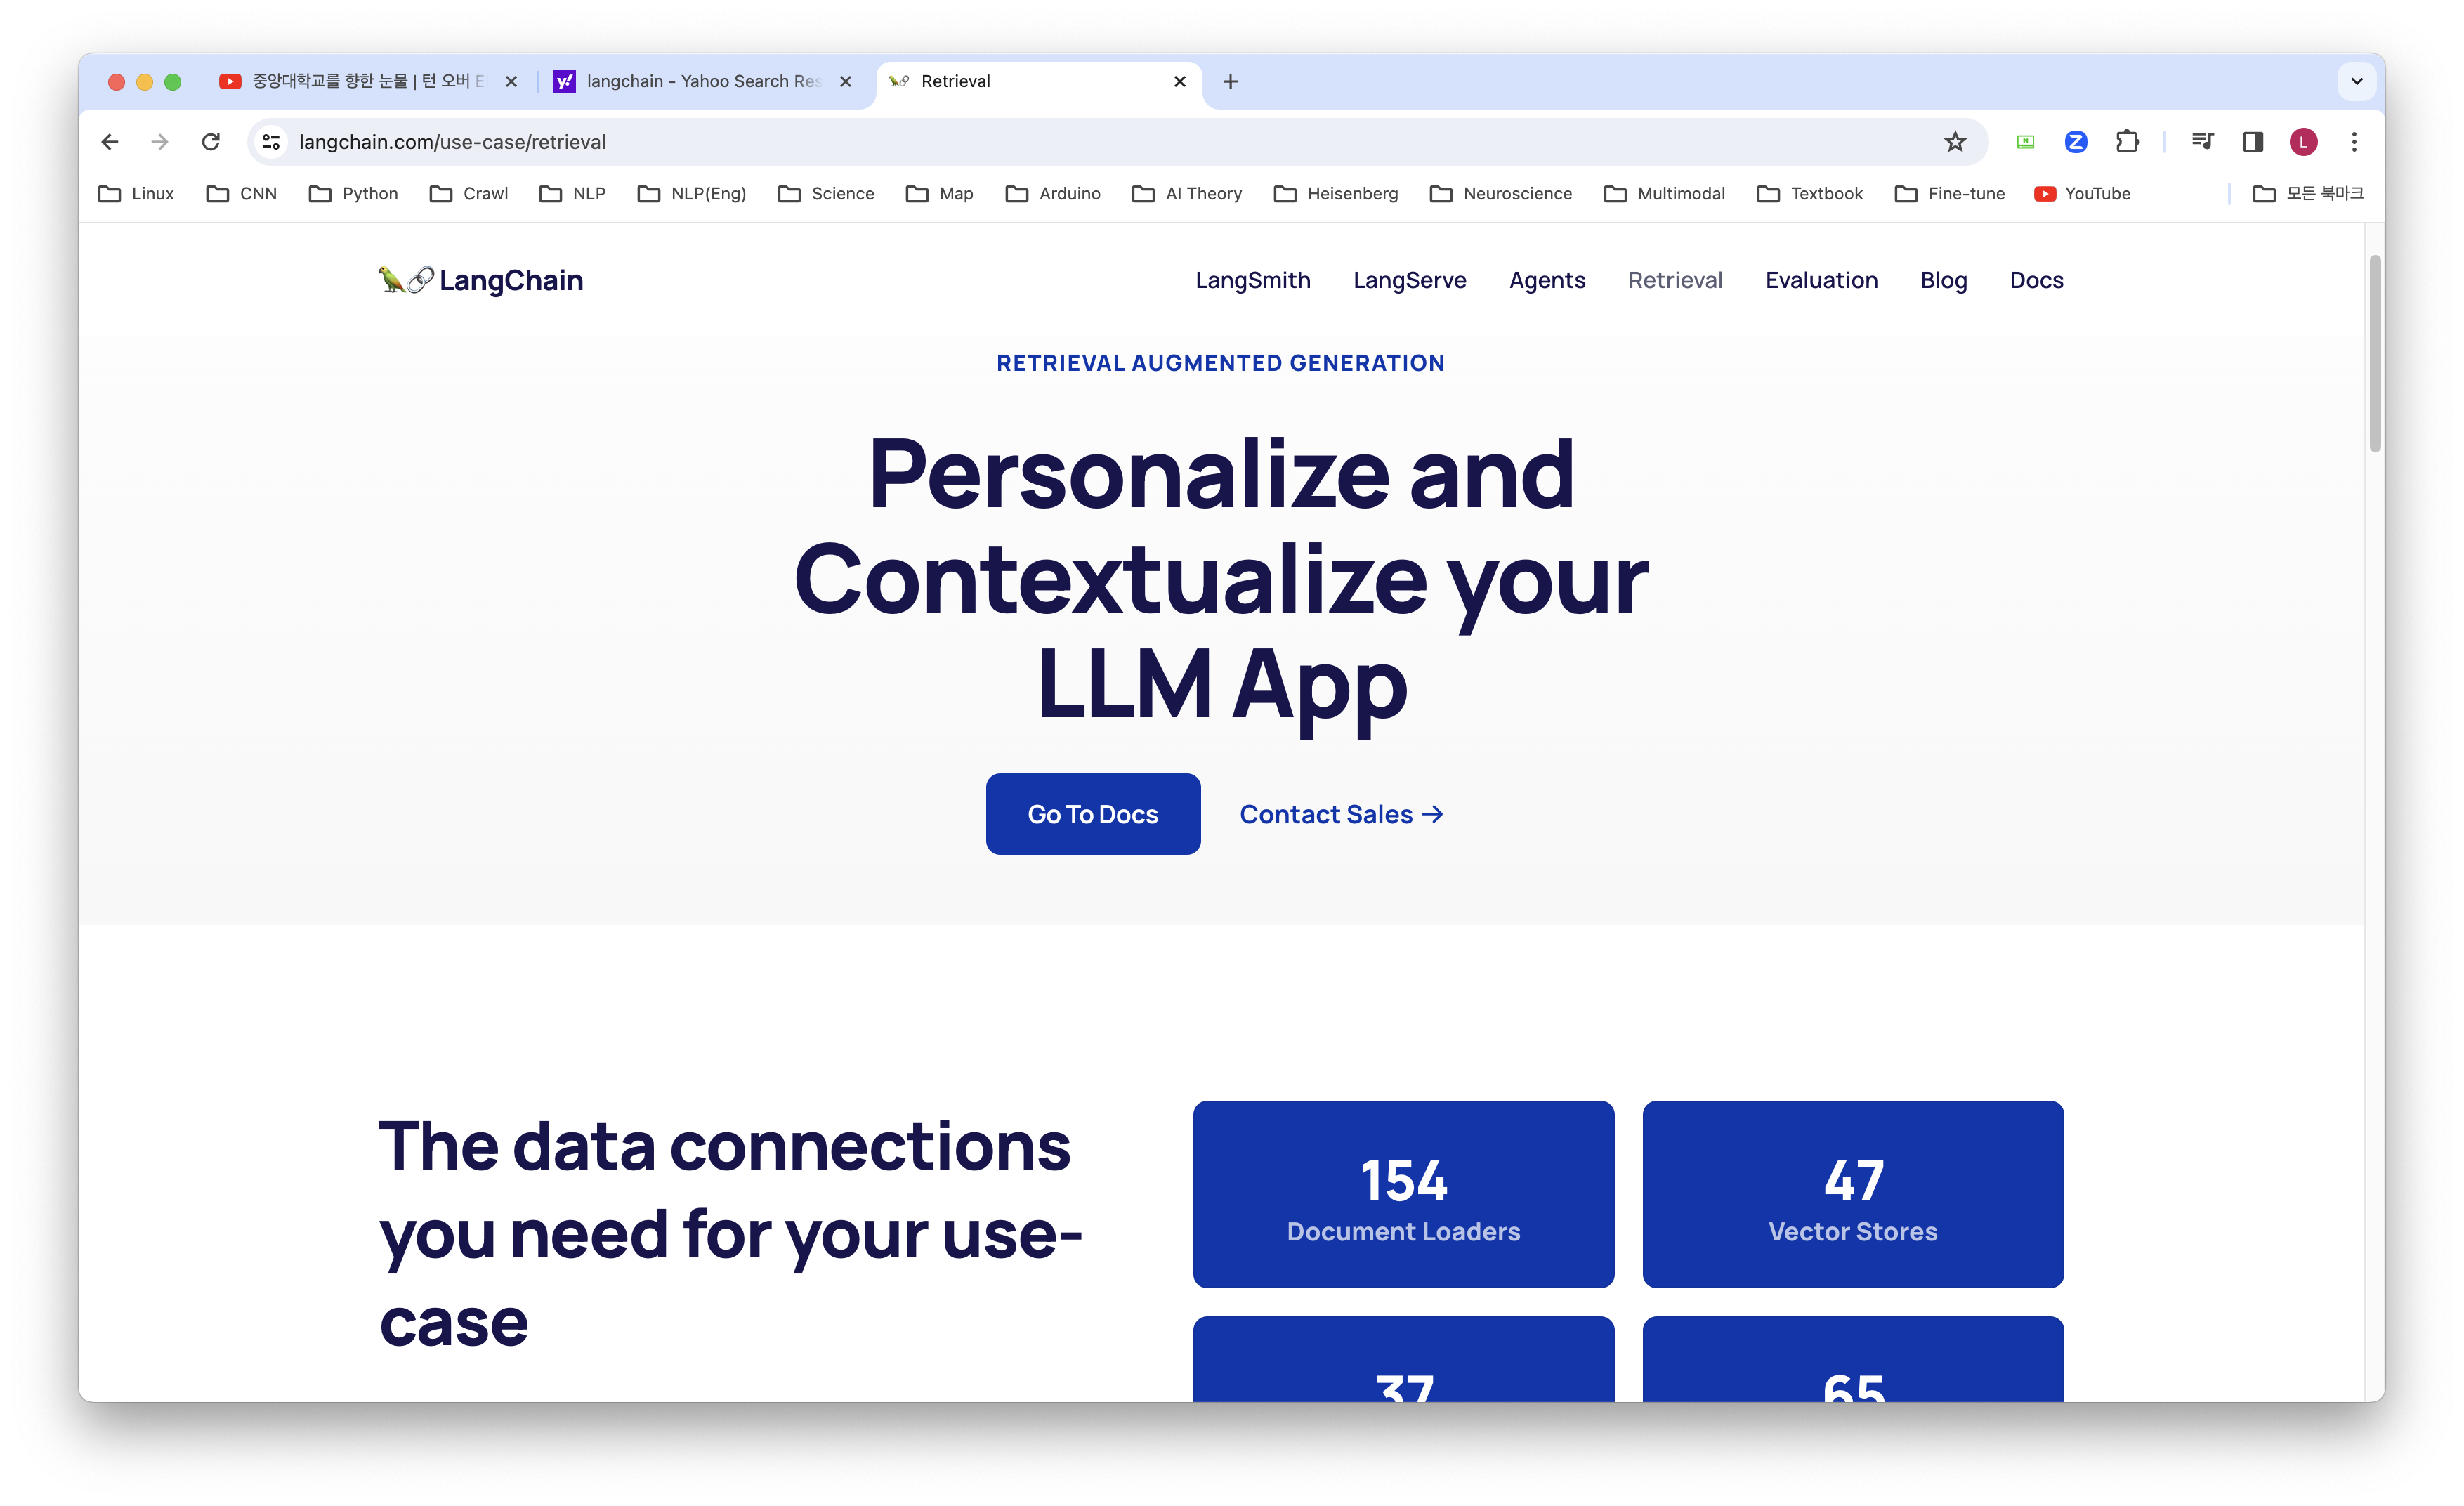

In [2]:
from openai._client import OpenAI #ChatGPT API 이용을 위한 라이브러리
from dotenv import load_dotenv #.env에서 파일을 읽어오기 위한 환경변수 처리 라이브러리
import os

load_dotenv() # 환경 파일 불러오기
client = OpenAI(api_key = os.getenv('OPENAI_API_KEY'))

TEMPERATURE = 0.0
MAX_TOKENS = 16000
MODEL = 'gpt-4-turbo'
context = [] # 리스트

# Read single PDF and ask questions about the file

In [ ]:
!pip install pypdf pypdf2 tiktoken

In [4]:
from PyPDF2 import PdfReader
from langchain.chains import AnalyzeDocumentChain
from langchain.chains.summarize import load_summarize_chain
from langchain import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()

# Person이라는 폴더에 있는 The scientific method as myth and ideal이라는 논문에 대해 열어 분석하고자 한다.
# 만약 다른 경로의 파일을 분석하고 싶다면 아래의 따옴표 안에 해당 경로와 파일 이름을 작성하면 가능하다.
reader = PdfReader("personal/the scientific method as myth and ideal.pdf")
raw_text = ""

for i, page in enumerate(reader.pages):
    text = page.extract_text()
    if text:
        raw_text += text

llm = OpenAI(temperature=0, model='gpt-3.5-turbo-instruct', openai_api_key = os.getenv('OPENAI_API_KEY'))
summary_chain = load_summarize_chain(llm, chain_type="map_reduce")
summarize_document_chain = AnalyzeDocumentChain(combine_docs_chain=summary_chain)
summarize_document_chain.run(raw_text)

' The article discusses the concept of "The Scientific Method" and its portrayal in popular and introductory contexts. It argues that there is no single method and that the traditional portrayal is inaccurate. The article also explores the role of social dynamics and values in scientific activity and suggests a pluralistic approach to teaching the scientific method. It also references previous critiques and alternative perspectives on the scientific method.'

## Analyse multiple douments

In [5]:
TEMPERATURE = 0.0
MAX_TOKENS = 16000
MODEL = 'gpt-4-turbo'
context = [] # 리스트

In [6]:
source_folder = 'personal'
# 폴더 내 모든 파일 리스트 가져오기
file_list = []
for root, dirs, files in os.walk(source_folder):
    for file in files:
        if file.endswith('.pdf'):
            file_list.append(os.path.join(root, file))

In [7]:
file_list

['personal/dynamic social representations of the 2009 h1n1 pandemic.pdf',
 'personal/underachievement among gifted students of color.pdf',
 'personal/the scientific method as myth and ideal.pdf']

In [8]:
from langchain.document_loaders import PyPDFLoader

documents = []

for name in file_list:
    print(f"{name} Loaded:::::")
    reader = PyPDFLoader(name)
    documents.extend(reader.load())

print (f'You have {len(documents)} document(s) in your data')

personal/dynamic social representations of the 2009 h1n1 pandemic.pdf Loaded:::::
personal/underachievement among gifted students of color.pdf Loaded:::::
personal/the scientific method as myth and ideal.pdf Loaded:::::
You have 51 document(s) in your data


In [9]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(chunk_size=4000, chunk_overlap=100) #chunk overlap seems to work better
documents2 = text_splitter.split_documents(documents)
print(len(documents2))

51


In [10]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import ConversationalRetrievalChain
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import Chroma

embeddings = OpenAIEmbeddings(model='text-embedding-ada-002', max_retries=20, openai_api_key=os.getenv('OPENAI_API_KEY'))
vectorstore = Chroma.from_documents(documents, embeddings) # 벡터화된 DB
model = ChatOpenAI(temperature=TEMPERATURE, model_name=MODEL, openai_api_key=os.getenv('OPENAI_API_KEY'))
qa = ConversationalRetrievalChain.from_llm(model, vectorstore.as_retriever())

/Users/heavenly/opt/anaconda3/envs/mqed/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
/Users/heavenly/opt/anaconda3/envs/mqed/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [11]:
def ask(question):
    result = qa({"question": question, "chat_history":[]})
    
    return result['answer']

In [12]:
result = ask('H1N1이 널리 퍼지게 된 이유가 뭐야?')
print(result)

/Users/heavenly/opt/anaconda3/envs/mqed/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


H1N1, 일명 신종 인플루엔자는 2009년에 처음 발생하여 전 세계적으로 빠르게 퍼졌습니다. 이 바이러스가 널리 퍼진 주된 이유는 여러 가지가 있지만, 주요 원인은 다음과 같습니다:

1. **고도의 전염성**: H1N1 바이러스는 사람 간에 매우 쉽게 전파될 수 있는 특성을 가지고 있습니다. 기침, 재채기, 신체 접촉을 통해 바이러스가 퍼질 수 있습니다.

2. **세계화와 이동성**: 2009년 당시 세계화가 진행되면서 국제 여행과 무역이 활발해졌습니다. 이로 인해 감염된 지역과 사람들이 빠르게 다른 지역으로 이동하면서 바이러스의 전파가 가속화되었습니다.

3. **초기 대응의 어려움**: H1N1 바이러스는 처음에 식별되었을 때 그 특성이 완전히 알려지지 않았고, 이로 인해 초기 대응이 늦어지거나 비효율적일 수 있었습니다. 이는 바이러스의 초기 확산을 막는 데 어려움을 초래했습니다.

4. **면역력 부족**: H1N1은 새로운 유형의 인플루엔자 바이러스였기 때문에 대부분의 사람들이 이 바이러스에 대한 면역력을 가지고 있지 않았습니다. 따라서 인구 중 많은 사람들이 감염될 수 있는 상황이었습니다.

이러한 요인들이 복합적으로 작용하여 H1N1 바이러스는 전 세계적으로 빠르게 퍼질 수 있었습니다.


In [13]:
result = ask('과학적 방법이라는 것은 존재할까?')
print(result)

과학적 방법에 대한 통일된 정의나 단일한 방법론이 존재한다는 것은 많은 역사가와 과학 철학자들 사이에서 의문시되고 있습니다. 과학적 방법이라는 용어는 다양한 과학적 문제를 해결하기 위해 개발된 방법들의 가장 낮은 공통 분모를 지칭할 수 있지만, 이것이 특정한 단계나 절차를 명확하게 규정하지는 않습니다. 실제로 과학자들이 사용하는 방법은 연구 분야나 특정 문제에 따라 크게 다를 수 있습니다. 따라서 '과학적 방법'이라는 용어는 과학적 활동의 일부 특징을 간략하게 설명할 수는 있지만, 모든 과학적 활동을 포괄적으로 설명하는 단일한 방법론으로 보기는 어렵습니다.


## Save the vector DB

In [14]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from chromadb.config import Settings

In [15]:
persist_directory = 'sample_db'
embeddings = OpenAIEmbeddings(model='text-embedding-ada-002', openai_api_key=os.getenv('OPENAI_API_KEY'), max_retries=20)

vectorstore = Chroma.from_documents(documents, embeddings, persist_directory=persist_directory) #문서로부터 불러오기
vectorstore.persist() # 벡터 DB 저장하기

/Users/heavenly/opt/anaconda3/envs/mqed/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


# Build up your own Conversational AI Agent

In [16]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.schema import AIMessage, HumanMessage, SystemMessage
import langchain
import os

In [17]:
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

persist_directory = 'sample_db'
embeddings = OpenAIEmbeddings(model='text-embedding-ada-002', openai_api_key=OPENAI_API_KEY, max_retries=20)
vectorstore = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

In [18]:
model = ChatOpenAI(temperature=0, model_name='gpt-4-turbo')
qa = ConversationalRetrievalChain.from_llm(model, 
                                           vectorstore.as_retriever(search_kwargs={"k": 3}), 
                                           return_source_documents=True)
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

In [19]:
def manage_history(lists):    
    tot_size = 0
    if len(lists) >= 1:
        for item in lists:
            tot_size += len(item.content)

        if tot_size >= 16000:
            lists = lists[2:]  # chat_history 전역 변수를 수정
        
        return lists
    else:
        return lists
        
def questioning(lists, query, show_ref=True):
    lists = manage_history(lists)
    
    result = qa({"question": query, "chat_history": lists})
    print(result['answer']) # 응답 출력
        
    #Reference 출력
    refs = []
    if show_ref: print('참고문헌:')
        
    for item in result['source_documents']:
        filename_with_extension = os.path.basename(item.metadata['source'])
        filename = os.path.splitext(filename_with_extension)[0]
        if show_ref: print(filename)
        refs.append(filename)
        
    lists.append(HumanMessage(content=query, additional_kwargs={}, example=False))
    lists.append(AIMessage(content=result['answer'], additional_kwargs={'source':refs}, example=False))
        
    return lists, refs

In [20]:
chat_history = []

In [21]:
chat_history, ref = questioning(chat_history, "H1N1가 유행했을 때 당시 사람들은 어떻게 생각했어?")

2009년 H1N1 인플루엔자 팬데믹에 대한 대중의 인식은 시간이 지남에 따라 변화했습니다. 초기에는 멀리 떨어진 국가들이 언급되었지만, 팬데믹이 진행되면서 지역적인 집단이나 위험군에 대한 언급으로 바뀌었습니다. 또한, 대중은 이 질병과 관련하여 다양한 집단을 영웅, 악당, 피해자로 묘사하는 경향이 있었습니다. 이러한 사회적 대표성의 변화는 언론 보도와 인터뷰를 통해 분석되었습니다.
참고문헌:
dynamic social representations
dynamic social representations
dynamic social representations


In [22]:
chat_history = questioning(chat_history, "감기는 어떻게 예방할 수 있어?")

제공된 자료에는 감기 예방 방법에 대한 구체적인 정보가 포함되어 있지 않습니다. 감기 예방에 대한 일반적인 조언을 원하신다면, 손을 자주 씻고, 면역 체계를 강화하기 위해 충분한 수면과 균형 잡힌 식사를 하는 것이 좋습니다. 또한, 감기에 걸린 사람과의 밀접한 접촉을 피하는 것도 중요합니다.
참고문헌:
dynamic social representations
dynamic social representations
dynamic social representations


## Loading Web information

In [23]:
from langchain.document_loaders import WebBaseLoader

In [24]:
urls = ['https://www.reuters.com/markets/us/investors-brace-5-treasury-yields-us-inflation-worries-mount-2024-04-26/',
        'https://www.freep.com/story/money/personal-finance/susan-tompor/2024/04/24/inflation-is-hot-but-not-enough-to-drive-i-bonds-to-sky-high-returns/73414755007/',
        'https://finance.yahoo.com/news/squint-eyes-us-inflation-data-170049394.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAJ9QqNwYsgFKgaJLXJqpVhSSeaW1AwgIs0asXQlqwaIJKA-sKczXHCxVuwrjXqHt8MSapsIN_aL6JDjFMyzE_Y9x4FPI8wirCTEyIXlAhNqcyh6k-xir8FGW_CCqjjVxOlD5yUIzvMZM8d5nMGOyu3jg6wgbDRLcfnXEMLiDg00V',
        'https://www.cnbc.com/2024/04/26/all-the-data-shows-inflation-isnt-going-away-making-things-tough-on-fed.html',
        'https://edition.cnn.com/2024/04/26/economy/us-europe-inflation-differences/index.html']

loader = WebBaseLoader(urls)
docs = loader.load()

In [25]:
persist_directory = 'news_db'
embeddings = OpenAIEmbeddings(model='text-embedding-ada-002', openai_api_key=os.getenv('OPENAI_API_KEY'), max_retries=20)
vectorstore = Chroma.from_documents(docs, embeddings, persist_directory=persist_directory)
vectorstore.persist()

In [26]:
model = ChatOpenAI(temperature=0, model_name='gpt-4-turbo')
qa = ConversationalRetrievalChain.from_llm(model, 
                                           vectorstore.as_retriever(search_kwargs={"k": 3}), 
                                           return_source_documents=True)
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
chat_history=[]

In [27]:
questioning(chat_history, "앞으로 어떤 채권을 사야 인플레이션에 대한 대비가 될까?")

죄송하지만 제공된 정보에는 인플레이션에 대비하기 위해 구매할 채권에 대한 구체적인 정보가 포함되어 있지 않습니다. 일반적으로 인플레이션에 대비하여 투자하는 방법으로는 인플레이션 보호 채권(TIPS) 또는 기타 인플레이션 연동 채권을 고려할 수 있습니다. 이러한 채권들은 인플레이션 상승에 따라 원금이 조정되어 인플레이션으로 인한 손실 위험을 줄일 수 있습니다. 자세한 투자 조언을 위해서는 금융 전문가와 상담하는 것이 좋습니다.
참고문헌:
squint-eyes-us-inflation-data-170049394
live-ftse-european-stocks-inflation-figures-wall-street-090142973
index


([HumanMessage(content='앞으로 어떤 채권을 사야 인플레이션에 대한 대비가 될까?'),
  AIMessage(content='죄송하지만 제공된 정보에는 인플레이션에 대비하기 위해 구매할 채권에 대한 구체적인 정보가 포함되어 있지 않습니다. 일반적으로 인플레이션에 대비하여 투자하는 방법으로는 인플레이션 보호 채권(TIPS) 또는 기타 인플레이션 연동 채권을 고려할 수 있습니다. 이러한 채권들은 인플레이션 상승에 따라 원금이 조정되어 인플레이션으로 인한 손실 위험을 줄일 수 있습니다. 자세한 투자 조언을 위해서는 금융 전문가와 상담하는 것이 좋습니다.', additional_kwargs={'source': ['squint-eyes-us-inflation-data-170049394', 'live-ftse-european-stocks-inflation-figures-wall-street-090142973', 'index']})],
 ['squint-eyes-us-inflation-data-170049394',
  'live-ftse-european-stocks-inflation-figures-wall-street-090142973',
  'index'])

In [28]:
questioning(chat_history, "미국 경제가 침체가 오게 되면 영국 파운드 화의 가치는 어떻게 변할까?")

제가 제공받은 정보에는 미국 경제 침체 시 영국 파운드의 가치 변동에 대한 구체적인 예측이 포함되어 있지 않습니다. 일반적으로, 경제 침체는 해당 국가의 통화 가치에 부정적인 영향을 미칠 수 있으며, 이는 글로벌 통화 시장에서 다른 통화와의 상대적 가치에 영향을 줄 수 있습니다. 그러나 통화 가치는 다양한 요인에 의해 영향을 받기 때문에, 미국 경제의 상태만으로 영국 파운드의 미래 가치를 정확히 예측하기는 어렵습니다. 경제, 정치, 중앙은행의 정책, 글로벌 시장의 변동성 등 다양한 요소가 통화 가치에 영향을 미칠 수 있습니다.
참고문헌:
index
index
british-pound-gbp-latest-gbp-usd-on-hold-ahead-of-inflation-report-20231218


([HumanMessage(content='앞으로 어떤 채권을 사야 인플레이션에 대한 대비가 될까?'),
  AIMessage(content='죄송하지만 제공된 정보에는 인플레이션에 대비하기 위해 구매할 채권에 대한 구체적인 정보가 포함되어 있지 않습니다. 일반적으로 인플레이션에 대비하여 투자하는 방법으로는 인플레이션 보호 채권(TIPS) 또는 기타 인플레이션 연동 채권을 고려할 수 있습니다. 이러한 채권들은 인플레이션 상승에 따라 원금이 조정되어 인플레이션으로 인한 손실 위험을 줄일 수 있습니다. 자세한 투자 조언을 위해서는 금융 전문가와 상담하는 것이 좋습니다.', additional_kwargs={'source': ['squint-eyes-us-inflation-data-170049394', 'live-ftse-european-stocks-inflation-figures-wall-street-090142973', 'index']}),
  HumanMessage(content='미국 경제가 침체가 오게 되면 영국 파운드 화의 가치는 어떻게 변할까?'),
  AIMessage(content='제가 제공받은 정보에는 미국 경제 침체 시 영국 파운드의 가치 변동에 대한 구체적인 예측이 포함되어 있지 않습니다. 일반적으로, 경제 침체는 해당 국가의 통화 가치에 부정적인 영향을 미칠 수 있으며, 이는 글로벌 통화 시장에서 다른 통화와의 상대적 가치에 영향을 줄 수 있습니다. 그러나 통화 가치는 다양한 요인에 의해 영향을 받기 때문에, 미국 경제의 상태만으로 영국 파운드의 미래 가치를 정확히 예측하기는 어렵습니다. 경제, 정치, 중앙은행의 정책, 글로벌 시장의 변동성 등 다양한 요소가 통화 가치에 영향을 미칠 수 있습니다.', additional_kwargs={'source': ['index', 'index', 'british-pound-gbp-latest-gbp-usd-on-hold-ahead-of-inflation-report-20231218']})],
 ['in

### Read CSV

In [ ]:
!pip install openpyxl

In [ ]:
!pip install langchain_experimental langchain-openai

In [29]:
from langchain_openai import ChatOpenAI
from langchain.agents import AgentType
from langchain.chains import ConversationalRetrievalChain
from langchain_experimental.agents import create_pandas_dataframe_agent
from dotenv import load_dotenv
import pandas as pd
import langchain
import os

In [30]:
load_dotenv()

True

In [31]:
df = pd.read_csv('Data/wos_gifted.csv', index_col=0)

In [32]:
llm = create_pandas_dataframe_agent(ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125"), 
                                      df, verbose=True, agent_type=AgentType.OPENAI_FUNCTIONS)

In [33]:
messages = [
    ("system", "You are a helpful assistant based on the given dataset."),
    ("human", "2010년에서 2015년까지 물리 분야 논문의 숫자는 몇 개야?"),
]

result = llm.invoke(messages)



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df_physic_papers = df[df['area'] == 'Science & Technology - Other Topics']\nphysic_papers_2010_2015 = df_physic_papers[(df_physic_papers['year'] >= 2010) & (df_physic_papers['year'] <= 2015)]\nphysic_papers_2010_2015_count = physic_papers_2010_2015.shape[0]\nphysic_papers_2010_2015_count"}`


15The number of physics papers from the dataset in the field of Science & Technology - Other Topics between 2010 and 2015 is 15.

> Finished chain.


In [34]:
result['output']

'The number of physics papers from the dataset in the field of Science & Technology - Other Topics between 2010 and 2015 is 15.'